# Exercise Sheet 3: Head Modeling & Non-linear dynamics

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as signal
def logistic(h,a=1):
    return 1/(1+np.exp(-a*h))

import os
os.chdir('C:/Users/Daniel Miklody/tubCloud/2020BCI-fNtD/exercises/data')

## Task 1: BEM vs infinite solution  (4 points)


The file 'cortex2dsm.npy', lets call it again $L$ is similar to the leadfields of the last sheet but this time mapping to the cortex surface. Again, you have to select a dipole and the dipolar moments $q$. The voltage is then calculated by $v=L_i \cdot q$.

**Tasks:**

a) Chose an arbitrary dipole and a dipolar moment yourself and simulate the field using the BEM head model.

b) Then, calculate the anayltical solution for an infinite homogeneous current dipole at the cortex surface vertices (positions) for the same source location and dipolar moment. Source conductivity is $\sigma_1=0.201$. You can find the source position $r_q$ for the dipole in 'gridpos.npy' which has the same indexing as the leadfield.

c) Plot the distribution of the potential on the brain surface using the *plot_trisurf* function similar as in task 7 sheet 2 in combination with indiviudally colored triangles.

c) Also, use the simple *plot* function to plot the voltage for both the analytic solution in infiinite space and the BEM soution on the cortex surface over the vertex index to get a closer look at individual values.

Are the solutions equal? Investigate and explain the difference. 

In [2]:
def phi_dip(r, Q, r_0=None,sigma=0.33):
    r=np.array(r)
    Q=np.array(Q)    
    if r_0 is not None:
        r_0=np.array(r_0)
        r=(r.T-r_0).T
    return 1/(4*np.pi*sigma)*(np.tensordot(Q,r,1))/np.power(np.linalg.norm(r,axis=0),3)

pos1=np.load('bnd4_pos1.npy')
tri1=np.load('bnd4_tri1.npy')

cortex2dsm=np.load('cortex2dsm.npy')
gridpos=np.load('gridpos.npy')
pos1=np.load('bnd4_pos1.npy')
tri1=np.load('bnd4_tri1.npy')
NoTri=tri1.shape[0]
NoPnt=pos1.shape[0]


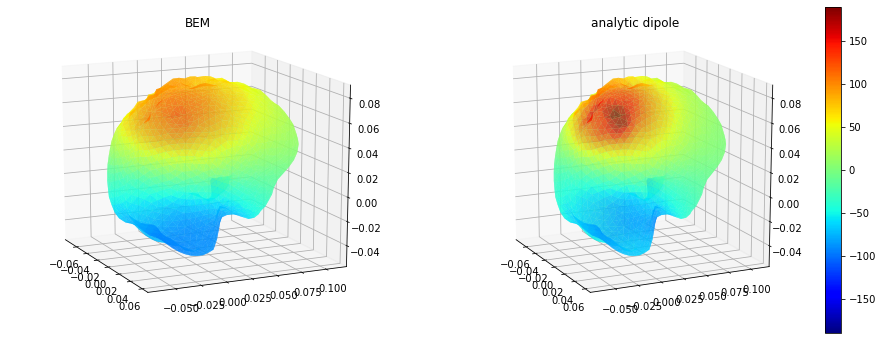

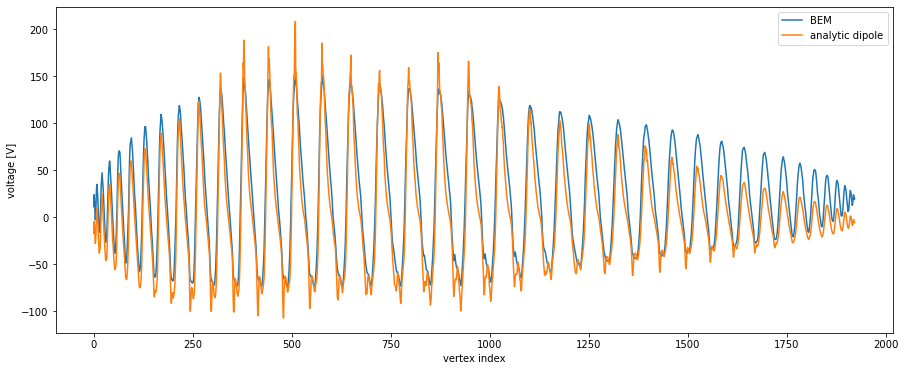

correlation:0.9728006493463162


In [3]:
iDip=2499
Q=np.array([0,0,1])

phis1=np.dot(cortex2dsm[:,iDip],Q)
phis1_tri=np.mean(phis1[tri1],axis=1)
phis1_tri=phis1_tri-np.mean(phis1_tri)

phis2=phi_dip(pos1.T,Q,gridpos[iDip],0.2010)
phis2_tri=phi_dip(np.mean(pos1[tri1,:],axis=1).T,Q,gridpos[iDip],0.2010)
phis2_tri=phis2_tri-np.mean(phis2_tri)

absmax=np.max(np.abs([phis1_tri,phis2_tri]))
mappy=plt.cm.ScalarMappable(cmap=plt.cm.jet)
mappy.set_clim([-absmax,absmax])
mappy.set_array([])

fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(121, projection='3d')
trisufplt=ax.plot_trisurf(pos1[:,0],pos1[:,1],pos1[:,2],triangles=tri1,linewidth=0.1,alpha=0.7)
trisufplt.set_facecolors(mappy.to_rgba(phis1_tri))
ax.view_init(elev=15, azim=-25)
plt.title('BEM')
ax = fig.add_subplot(122, projection='3d')
trisufplt=ax.plot_trisurf(pos1[:,0],pos1[:,1],pos1[:,2],triangles=tri1,linewidth=0.1,alpha=0.7)
trisufplt.set_facecolors(mappy.to_rgba(phis2_tri))
ax.view_init(elev=15, azim=-25)
plt.title('analytic dipole')
plt.colorbar(mappable=mappy,fraction=0.05)
plt.show()

fig = plt.figure(figsize=[15,6])
plt.plot(phis1)
plt.plot(phis2)
plt.legend(['BEM','analytic dipole'])
plt.xlabel('vertex index')
plt.ylabel('voltage [V]')
plt.show()

print('correlation:' + str(np.corrcoef(phis1,phis2)[0,1]))

**Answer:** The solutions are similar but not equal. While the correlation is very high, the infinite solution has higher and sharper peaks. This is called the "spatial smearing" of the fields that already takes place on the cortex surface because all changes of conductivity have an effect on the whole volume conduction. These are mainly the high conductivity of the CSF, the low conductive skull and the non-conductive air surrounding the head. While the CSF "attracts" the current flow and should promote more focused dipolar structure of lower amplitude, it is counteracted by the other two.

## Task 2: The effect of the non-linear transfer function: simulation (4 points)


**Tasks:**

a) Write a function simulating a sine-wave $x(t)=a*sin(\omega t)+b=a*sin(2\pi f t)+b$. Simulate a time interval of 10s with a sampling rate of fs=200Hz and plot it over the first $0.5s$ with $a=1$ for the amplitude, $b=0$ for the offset and $f=10Hz$ for the frequency.

b) Calculate the Power-Spectral-Density (PSD) of the signal and plot it over the frequency. For calculating the PSD, use the welch algorithm (scipy.signal.welch) and plot it using a logarithmic scale (10*log10(Pxx)). Clip the PSD below -80dB (i.e. only plot it until that value).

c) Use the logistic function $y(x)=\frac{1}{1-e^{ax}}$ on the signal $x(t)$ as a non-linear time-invariant amplitude transformation. Do this for all possible combinations of the following amplitudes and offsets of the sine wave: a={0.5, 1, 10} and b={-2,-1,0, 1, 2}. Calculate and plot the PSD as in b).

d) The signal is a pure sine wave, which as a fourier transform has a single peak in the frequency spectrum. Explain the differences to the PSD of the sine wave (b) and the effect of the non-linear transformation on the PSD (c).

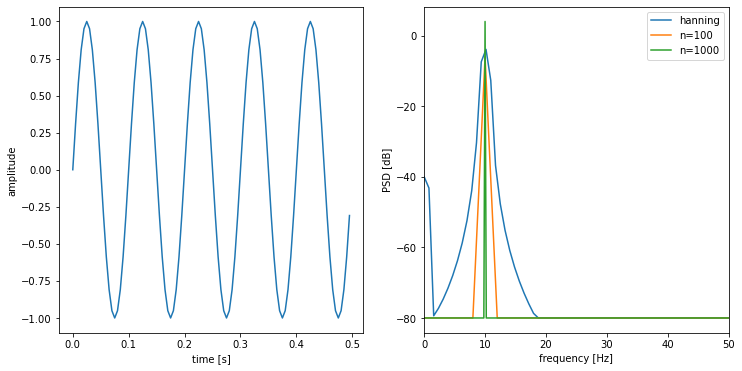

In [4]:
fs=200
t=np.arange(0,10,1/fs)

sinesig=lambda t,a,b,f0:a*np.sin(2*np.pi*f0*t)+b
x=sinesig(t,1,0,10)

plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(t[:100],x[:100])
plt.xlabel('time [s]')
plt.ylabel('amplitude')

f,Pxx=signal.welch(x,fs)
f2,Pxx2=signal.welch(x,fs,np.ones(100))
f3,Pxx3=signal.welch(x,fs,np.ones(1000))

Pxx=10*np.log10(Pxx)
Pxx[Pxx<-80]=-80
Pxx2=10*np.log10(Pxx2)
Pxx2[Pxx2<-80]=-80
Pxx3=10*np.log10(Pxx3)
Pxx3[Pxx3<-80]=-80

plt.subplot(122)
plt.plot(f,Pxx)
plt.plot(f2,Pxx2)
plt.plot(f3,Pxx3)
plt.xlim([0,50])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.legend(['hanning','n=100','n=1000'])

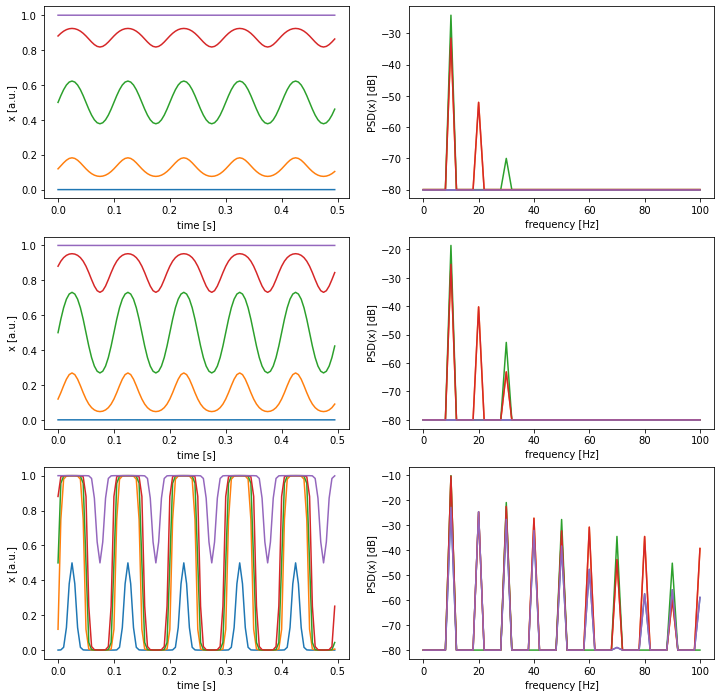

In [5]:
a=[0.5,1,10]
b=[-10,-2,0,2,10 ]

fig1=plt.figure(figsize=[12,12])
#fig2=plt.figure(figsize=[12,6])
for i in range(len(a)):
    spl1=plt.subplot(len(a),2,2*i+1)
    spl2=plt.subplot(len(a),2,2*i+2)
    for j in range(len(b)):
        x=sinesig(t,a[i],b[j],10)
        x_nl=logistic(x)
        
        plt1=spl1.plot(t[:100],x_nl[:100])
        
        #I set n to 100 in order to make the peaks well distingishuable within one common plot.
        f,Pxx_nl=signal.welch(x_nl,fs,np.ones(100))
        Pxx_nl=10*np.log10(Pxx_nl)
        Pxx_nl[Pxx_nl<-80]=-80
        #plt.figure(fig2.number)
        #plt.subplot(len(a),2,2*i+2)
        plt2=spl2.plot(f,Pxx_nl)
    
    spl1.set(xlabel='time [s]', ylabel='x [a.u.]')
    spl2.set(xlabel='frequency [Hz]', ylabel='PSD(x) [dB]')

**Answer to d):** The pure sine wave has a PSD consisting of two peaks, one at f=0Hz and one at f=10Hz, that are not fully sharp. This is due to the effect of the welch algorithm which uses short time windows (peak width) that are weighted with a hanning window (peak at f=0). 
Soft-clipping the signal with the sigmoid function introduces harmonics to the spectrum that depend on the offset and the amplitude. While the amplitude has an effect on peak height and the spectral roll-off of the harmonics, the offset determines the composition of the peaks. A symmetric clipping (offset=0) interestingly only has odd harmonics. 

## Task 3: The effect of the non-linear transfer function: analytic & simulation (5 points)

*Disclaimer: This exercise was not fully matured when it was published due to the author experienceing major timing issues and being drastically over-worked at that time. The author apologizes for this unprofessional behaviour and promises to improve. The task can be solved as it is but some conceptional errors in the transfer to the clipping of sine waves remain. One of these is that the level of the cut-off is not properly cared off. A second rectangular periodic function would have to be added to care for the sine-off level that is not zero but the cut-off. Also, the intended simplification to a one-sided amplitude spectrum is not fully correct. Additionally , the transform of the rectangular wave does not have the sine² but the sine in the counter. A final evaluation and discussion will be done in the tutorial. The solution of this exercise, however, shows some of the basic principles.*

With a little trick, the clipping of an oscillating signal like a cosine wave y(t) can be seen as a linear operation: the multiplication with a rectangular oscillation x(t) of same frequency and apropriate phase. We ignore the DC part in this exercise. This models the "on/off" effect of the clipping:

$z(t)=x(t)y(t)$

For the periodic rectangular time series defined within a period $T_0=\frac{1}{f_0}$ (note that this is a little bit different than in the lecture):

$x (t) = \left\{
\begin{array}{ll}
1  & \, \textrm{for} \left|t\right| \leq \frac{T_1}{2} \\
0 & \, \textrm{else} \\
\end{array}
\right.$

the corresponding fourier transform (here one-sided) is based on the delta function:

$\hat{x}(f)=\frac{T_1}{T_0} \delta(f)+\sum_{n=1}^\infty \frac{\sin(\pi n\frac{T_1}{T_0})}{\pi n} \delta(f-\frac{n}{T_0})$

A cosine wave of frequency $f_0$ has the fourier transform:

$\hat{y}(f)=2 \pi \delta (f+f_0)$

In the theory of Fourier Transformation, a multiplicatiion in time domain corresponds to a convolution in the frequency:

$z(t)=x(t)y(t) <=> z(f)=\hat{x}(f) * \hat{y}(f)$

with the convolution being:

$\hat{x}(f)*\hat{y}(f)=\int_{-\infty}^{\infty}\hat{x}(f-f')\hat{y}(f')df'$

**Task:**

a) Calculate the Fourier Transform $\hat{z}(f)$ of the signal $z(t)$ analyitcally by convolving $\hat{x}(f)$ and $\hat{y}(f)$ in the frequency domain.

b) Implement the corresponding function for plotting and plot the amplitde spectrum for the clipped 10Hz sine wave. Set $T_1$ consequently to $\frac{1}{4}T_0$, $\frac{1}{2}T_0$ and $\frac{3}{4}T_0$. Plot the delta function using the matplot functiion stem. What are the corresponding clipping values?

c) Investigate the values at $nf_0$ and their dependency on the frequency.
What is the effect of the clipping in the spectrum? What implications does the non-linear effect of clipping have on clipped sine waves (single frequency peaks) and white noise (spectrum is constant over frequency)?


*Hint: For the convolution, think about the special properties of the dirac delta function $\delta(x)$.

$\hat{z}(f)=\hat{x}(f)\hat{y}(f)=\int_{-\infty}^{\infty}\hat{x}(f-f')\hat{y}(f')df'=2\pi\int_{-\infty}^{\infty}\hat{x}(f-f')\delta (f'-f_0))df'$

$=2\pi \hat{x}(f-f_0)$

$=2\pi \frac{T_1}{T_0} \delta(f-f_0)+\sum_{n=1}^\infty \frac{\sin^2(\pi n\frac{T_1}{T_0})}{\pi n} \delta(f-f_0-\frac{n}{T_0})$

$=2\pi \frac{T_1}{T_0} \delta(f-f_0)+\sum_{n=1}^\infty \frac{\sin^2(\pi n\frac{T_1}{T_0})}{\pi n} \delta(f-(1+n) f_0)$

<ipython-input-6-08da17a578a0>:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(f,np.abs(z))
<ipython-input-6-08da17a578a0>:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(f,np.abs(z))
<ipython-input-6-08da17a578a0>:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "

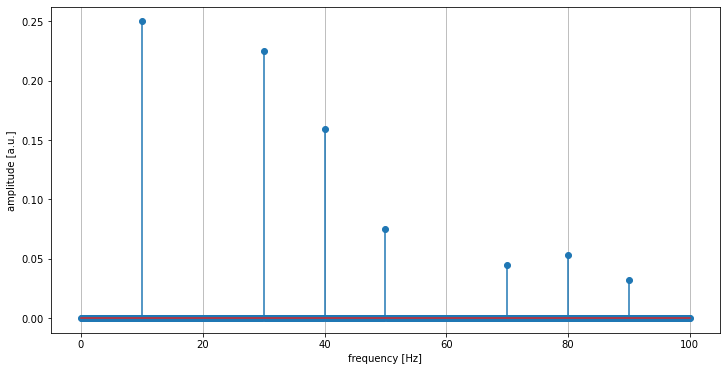

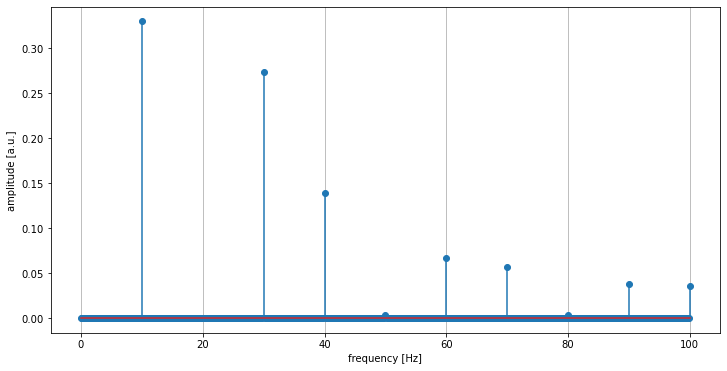

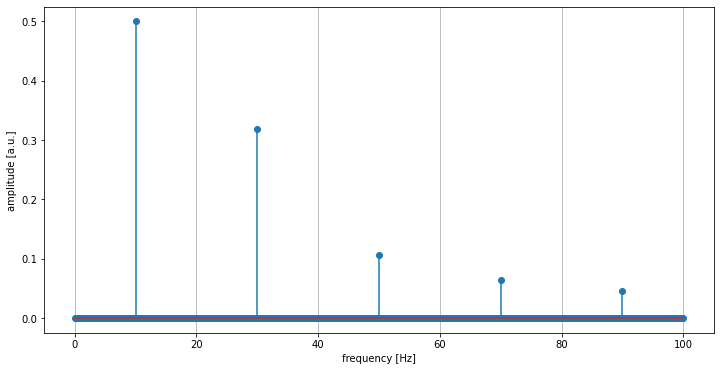

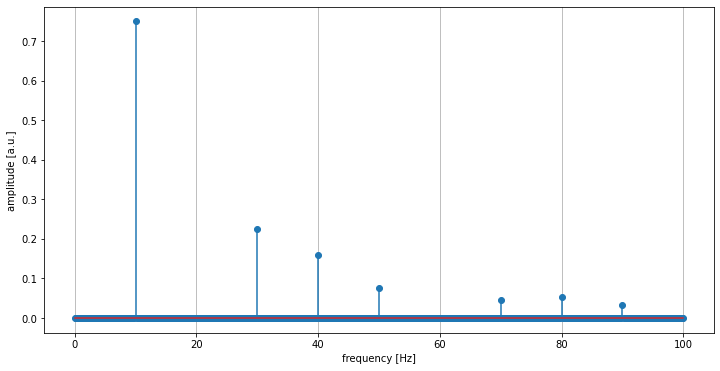

In [6]:
def x_hat(f,T0,T1):
    #x=np.zeros(f.shape)
    x=T1/T0*(f==0)
    for k in range(int(np.floor(f.max()/T0))):
        n=k+2
        x=x+np.sin(np.pi*(n-1)*T1/T0)/(np.pi*(n-1))*(np.abs(f-n/T0)<=np.finfo(float).eps)  #numerically zero   
    return x

f0=10
T0=1/(f0)
Tratios=[0.25, 0.33, 0.5 ,0.75]

for Tratio in Tratios:
    T1=Tratio*T0
    f=np.linspace(0,100,501)
    x=x_hat(f,T0,T1)
    
    z=x_hat(f-f0,T0,T1)
    plt.figure(figsize=[12,6])
    plt.stem(f,np.abs(z))
    plt.grid(axis='x')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amplitude [a.u.]')


**Answers:**

**b) What are the corresponding clipping values?**
They are $\cos ( \pi \frac{T_1}{T_0})$. 

**c) Investigate the values at $nf_0$ and their dependency on the frequency.**
The values are  $\frac{\sin(\pi n\frac{T_1}{T_0})}{\pi n}$ and thus resemble values related to the sinc function. The oscillating amplitude ($\sin$) decays with frequency ($1/n$) which produces spectra thematically related to 1/f decay in EEG.

**What is the effect of the clipping in the spectrum?**
(Hard-) clipping introduces harmonics depending on the clipping value, while the spectral roll-off is fixed to 1/f (in contrast to soft-clipping).

**What implications does the non-linear effect of clipping have on clipped sine waves (single frequency peaks) and white noise (spectrum is constant over frequency)?**
Clipping of sine/cosine waves introduces an infinite sum of spectral peaks that are at natural number multiples of the original frequency decaying with frequency (1/f). 

The clipping of white-noise produces white noise again. You might think that it consists of infinitely many sine waves at infinitely many frequencies which would also produce a spectrum decaying with frequency but due to the white noise being non-oscillatory (non-repetitive/memoryless) this does not happen.